# Overview
The purpose of this notebook is to evaluate a new set of book covers using the scoring model that was trained using the RankNet architecture. Then, on a week by week basis, we will compare the proposed ordering given by the model, with the actual one and compute the NDCG (Normalized Discounted Cumulative Gain).

## Config

In [35]:
import cloudpickle
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import re

In [4]:
holdout_embeddings = cloudpickle.load(open('./embedding_dictionary_holdout.pkl','rb'))

In [5]:
model = tf.keras.models.load_model('./cover_ranker')

2022-03-01 08:49:12.395912: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-01 08:49:12.395956: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-espigfr): /proc/driver/nvidia/version does not exist
2022-03-01 08:49:12.396251: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Scoring

In [21]:
scores = {}
for k, v in holdout_embeddings.items():
    scores[k] = model(tf.expand_dims(v, 0)).numpy().reshape(-1)[0]

In [29]:
df_scores = pd.DataFrame({'ISBN':list(scores.keys()), 'score':list(scores.values())})
df_scores

,ISBN,score
0,978843062434,-0.349543
1,978842704794,-0.619631
2,978841342625,-0.581446
3,978841848350,-0.564247
4,978849998889,-0.571211
...,...,...
235,978840824391,-0.611650
236,978847141961,-0.589069
237,978846635935,-0.533427
238,978841213533,-0.587698


In [30]:
df_scores.to_csv('weekly_scores.csv', index = False)

## Assessment
To compare the ideal ordering with the model results, we will use the NDCG or normalized discounted cumulative gain. 
For every week of the holdout dataset, we will retrieve the ordering of the candidates and compare it to their proposed scores

In [68]:
score = [5]
score.extend([3 for i in range(4)])
score.extend([2 for i in range(10)])
score.extend([1 for i in range(35)])
score.extend([0 for i in range(50)])

In [69]:
def compute_idcg(scores):
    return np.sum([s/np.log2(i+2) for i, s in enumerate(scores)])

In [82]:
xl = pd.ExcelFile('./holdout_weekly_ranks.xls')
sheets = xl.sheet_names  # see all sheet names
NDCG = []
MRR = []
for sheet in tqdm(sheets):
    data = xl.parse(sheet).reset_index()
    data['true_score'] = score
    data['ISBN_key'] = [re.sub('-','',i)[:12] for i in data.ISBN]
    proposed_scores = df_scores.merge(data.loc[:,['true_score', 'ISBN_key']], left_on = 'ISBN', right_on = 'ISBN_key').sort_values('score', ascending = False).reset_index(drop=True)
    mrr = proposed_scores[proposed_scores.true_score == 5].index[0]+1
    ndcg = compute_idcg(proposed_scores['true_score'])/compute_idcg(data['true_score'])
    NDCG.append(ndcg)
    MRR.append(mrr)

100%|██████████| 12/12 [00:00<00:00, 108.87it/s]


<AxesSubplot:>

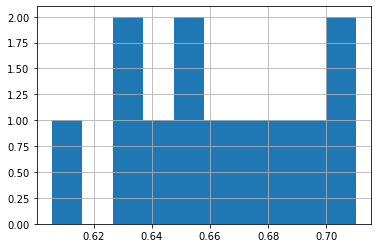

In [83]:
NDCG = pd.Series(np.array(NDCG))
NDCG.hist()

<AxesSubplot:>

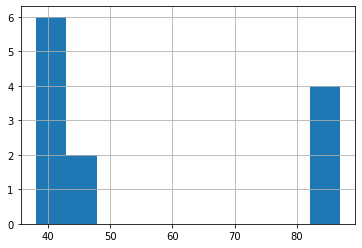

In [84]:
MRR = pd.Series(np.array(MRR))
MRR.hist()

In [76]:
NDCG.describe()

count    12.000000
mean      0.662422
std       0.032966
min       0.605585
25%       0.637379
50%       0.657759
75%       0.688574
max       0.710270
dtype: float64

On average, the ranker obtains a 65% performance compared to the perfect ordering. This is not optimal, but it is better than a random ordering, and also the range of NDCG is between 60 and 70%, which means that, although the proposed ranking is not perfect, it is robust.

The MRR however, on the 40s-50s in most of the cases, is not a positive sign, and the scoring model is not good pinpointing the best selling book of the week based on its cover design. 